### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 1


### Дисциплина: Методы машинного обучения

##### Студент:  Матюхин Григорий Васильевич
##### Группа:   НПИбд-01-21

## Москва 2024
***

### Вариант №7

1. Набор данных: efron_morris75 
2. Независимая переменная: RemainingAverage 
3. Зависимая переменная: SeasonAverage 
4. Визуализация для независимой переменной – диаграмма размаха 
5. Визуализация для зависимой переменной – эмпирическая функция распределения 
6. Показатель качества регрессии – R^2 (коэффициент детерминации) 


# Выполнение

# Step 1: Загружаем датасет

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

2024-04-17 00:17:30.511417: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 00:17:30.514920: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 00:17:30.570001: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 00:17:31.499005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds = tfds.load("efron_morris75", split="train")
df = tfds.as_dataframe(ds)
len(df)

2024-04-17 00:17:32.926665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


18

In [3]:
df.head()

,At-Bats,BattingAverage,FirstName,Hits,LastName,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonAverage,SeasonHits
0,45,0.289,b'Don',13,b'Kessinger',586,0.2645,631,0.266,168
1,45,0.178,b'Thurman',8,b'Munson',408,0.3162,453,0.302,137
2,45,0.222,b'George',10,b'Scott',435,0.3034,480,0.296,142
3,45,0.222,b'Billy',10,b'Williams',591,0.3299,636,0.251,205
4,45,0.311,b'Jim',14,b'Spencer',466,0.2704,511,0.274,140


In [4]:
df.drop(columns=["FirstName", "LastName", "At-Bats", "Hits", "SeasonAt-Bats", "SeasonHits", "RemainingAt-Bats"], inplace=True)
df.head()

,BattingAverage,RemainingAverage,SeasonAverage
0,0.289,0.2645,0.266
1,0.178,0.3162,0.302
2,0.222,0.3034,0.296
3,0.222,0.3299,0.251
4,0.311,0.2704,0.274


In [5]:
split = 0.8
idx = int(len(df) * split)
train, test = df[:idx], df[idx:]
len(train), len(test)

(14, 4)

### Анализ датасета

In [6]:
import pandas as pd

In [7]:
corr=train.corr()
corr

,BattingAverage,RemainingAverage,SeasonAverage
BattingAverage,1.000000,0.253028,0.545219
RemainingAverage,0.253028,1.000000,0.830656
SeasonAverage,0.545219,0.830656,1.000000


In [8]:
a, b = corr.stack().idxmin()
print("Min correlation:\n", corr.loc[[a], [b]])

Min correlation:
                 RemainingAverage
BattingAverage          0.253028


In [9]:
corr = corr.stack()
corr = corr[corr != 1.0]
a, b = corr.idxmax()
print("Max correlation:\n", corr.loc[[a], [b]])

Max correlation:
 RemainingAverage  SeasonAverage    0.830656
dtype: float64


## Step 2: Visualisation

<Axes: title={'center': "Box plot for 'RemainingAverage'"}>

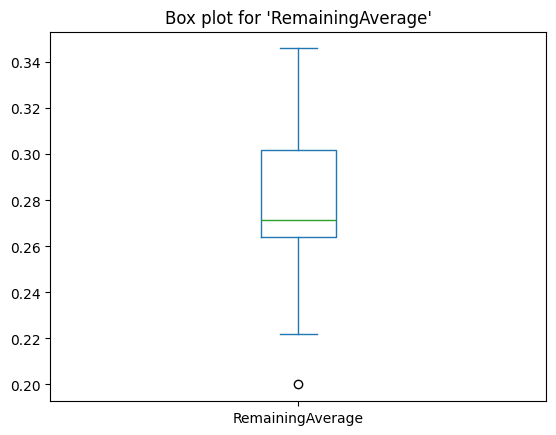

In [10]:
# Todo: not sure if a box with legent is needed here as there's only one value
train["RemainingAverage"].plot.box(title="Box plot for 'RemainingAverage'")

In [11]:
import numpy as np

In [12]:
# Note: the reference uses a different implementation of the algo
# so it looks more like a ladder
# look at ~[87] and further for comparison
sq = train["SeasonAverage"].value_counts()
ecdf = sq.sort_index().cumsum()*1./len(sq)
ecdf

SeasonAverage
0.183    0.071429
0.238    0.142857
0.251    0.214286
0.258    0.285714
0.261    0.357143
0.266    0.428571
0.267    0.500000
0.274    0.571429
0.276    0.642857
0.279    0.714286
0.296    0.785714
0.302    0.857143
0.306    0.928571
0.352    1.000000
Name: count, dtype: float64

<Axes: title={'center': "ECDF plot for 'SeasonAverage'"}, xlabel='SeasonAverage'>

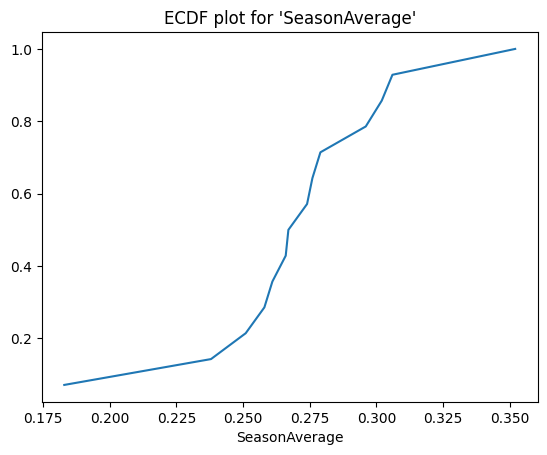

In [13]:
ecdf.plot.line(title="ECDF plot for 'SeasonAverage'")

## Step 3: Scatter plot

<Axes: title={'center': "Scatter plot for 'RemainingAverage' and 'SeasonAverage"}, xlabel='RemainingAverage', ylabel='SeasonAverage'>

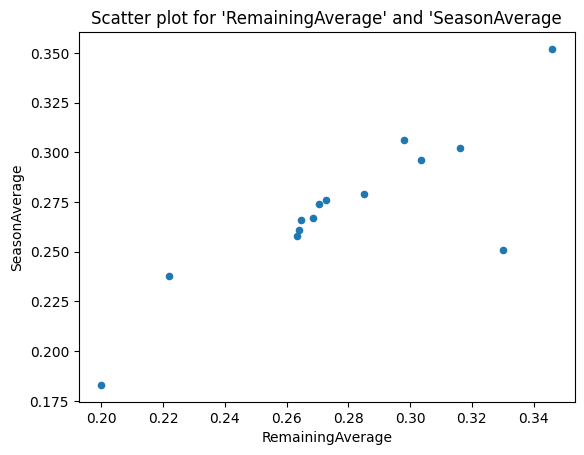

In [14]:
train.plot.scatter("RemainingAverage", "SeasonAverage", title="Scatter plot for 'RemainingAverage' and 'SeasonAverage")

In [15]:
# Todo: cleanup the dataset, we got some outliers to the top-right and middle-right, "

## Step 4: Linear regression

### Using numerical methods (Todo: name?)

In [16]:
import matplotlib.pyplot as plt

In [17]:
x = train["RemainingAverage"]
y = train["SeasonAverage"]
x_test = test["RemainingAverage"]
y_test = test["SeasonAverage"]

In [19]:
x_mean = np.mean(x)
y_mean = np.mean(y)

In [20]:
a = (x - x_mean).dot(y - y_mean) / (x - x_mean).dot(x - x_mean)
b = y_mean - a * x_mean
a, b

(0.8121717, 0.04559733)

In [21]:
y_hat = a * x + b
y_hat = np.array(y_hat) # Todo: put all this into a function
y_hat

array([0.26041675, 0.302406  , 0.29201025, 0.31353277, 0.26520854,
       0.25960457, 0.27698505, 0.26707655, 0.25992945, 0.20803167,
       0.32660872, 0.26374662, 0.225737  , 0.28770572], dtype=float32)

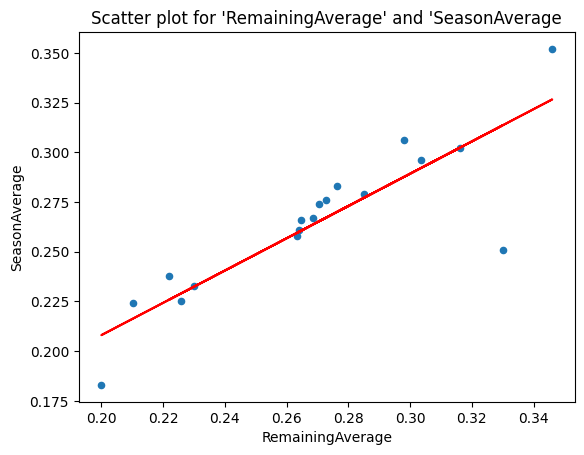

In [22]:
plt = df.plot.scatter("RemainingAverage", "SeasonAverage", title="Scatter plot for 'RemainingAverage' and 'SeasonAverage")
plt.plot(x, y_hat, color="r")

In [23]:
mse = np.sum((y_hat - y_test) ** 2) / len(y_test)
mse # what?

ValueError: operands could not be broadcast together with shapes (14,) (4,) 

In [ ]:
r2 = 1 - mse/np.var(y_test)
r2

### Using a neuron

In [24]:
tf.__version__

'2.16.1'

In [25]:
model = tf.keras.Sequential( [tf.keras.layers.Dense(1, input_shape=(1,))])
model.summary()

/home/gmatiukhin/Study/year3/ml-methods/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
    metrics=["r2_score"]
)

In [27]:
model.fit(x, y, epochs=100, verbose=0)

In [28]:
model_predict = model.predict(x)
model_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.24904603],
       [0.29546505],
       [0.28397256],
       [0.30776566],
       [0.25434336],
       [0.24814819],
       [0.26736227],
       [0.25640845],
       [0.24850734],
       [0.19113447],
       [0.3222211 ],
       [0.25272724],
       [0.21070768],
       [0.2792139 ]], dtype=float32)

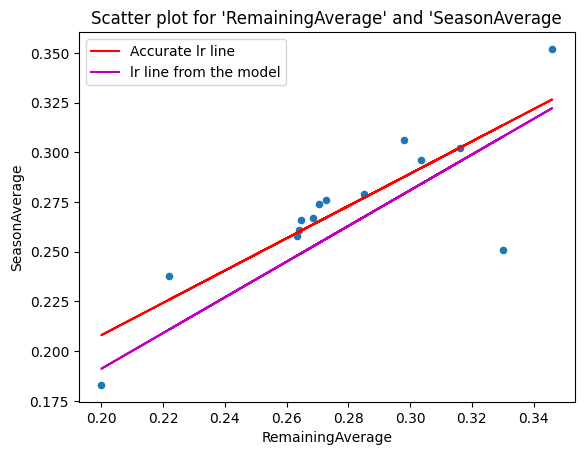

In [29]:
plt = train.plot.scatter("RemainingAverage", "SeasonAverage", title="Scatter plot for 'RemainingAverage' and 'SeasonAverage")
plt.plot(x, y_hat, color="r", label="Accurate lr line")
plt.plot(x, model_predict, color="m", label="lr line from the model")
plt.legend()

In [30]:
loss, r2_model = model.evaluate(x_test, y_test)
r2_model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0182 - r2_score: 0.3909


0.3909198045730591

In [31]:
r2, r2_model

NameError: name 'r2' is not defined